In [1]:
import pandas as pd 
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch.optim as optim
from itertools import product
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import StratifiedKFold

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
class VisualClassifier(nn.Module):
    def __init__(self):
        super(VisualClassifier, self).__init__()
        self.fc1 = nn.Linear(2048, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(0.7)
        self.fc2 = nn.Linear(256, 4)
        self.bn2 = nn.BatchNorm1d(4)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.fc2(x)))
        return x

In [4]:
class TextClassifier(nn.Module):
    def __init__(self, input_dim = 768, output_dim = 4, hidden_dim = 512):
        super(TextClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.bn2 = nn.BatchNorm1d(hidden_dim // 2)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(hidden_dim // 2, output_dim)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x


In [5]:
class AudialClassifier(nn.Module):
    def __init__(self):
        super(AudialClassifier, self).__init__()
        self.fc1 = nn.Linear(128, 16)
        self.bn1 = nn.BatchNorm1d(16)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(16, 4)
        self.bn2 = nn.BatchNorm1d(4)
   
    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.fc2(x)))
        return x

In [6]:
def train_model(model, dataloaders, optimizer, criterion, device, num_epochs = 50, patience = 10):

    """
    Trains and validates the model.
    
    Args:
    - model (torch.nn.Module): The PyTorch model to train.
    - dataloaders (dict): A dictionary containing 'train' and 'val' DataLoaders.
    - optimizer (torch.optim.Optimizer): The optimizer to use for training.
    - criterion (torch.nn.Module): The loss function.
    - num_epochs (int): The number of epochs to train for.
    - patience (int): The patience for early stopping.
    """
    best_val_f1 = -float('inf')  
    patience_counter = 0
    model.to(device)
    
    for epoch in range(num_epochs):
        model.train()
        for inputs, labels in dataloaders['train']:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        val_preds = []
        val_labels = []
        val_probs = []
        with torch.no_grad():
            for inputs, labels in dataloaders['val']:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
                val_probs.extend(outputs.cpu().numpy())


        val_accuracy = np.mean(np.array(val_preds) == np.array(val_labels))
        val_f1 = f1_score(val_labels, val_preds, average='micro')
        
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1  
            patience_counter = 0  
            # print(f"Validation F1 improved. Saving model...")
            # torch.save(model.state_dict(), 'best_model_checkpoint.pth')
        else:
            patience_counter += 1 
            # print(f'Validation F1 did not improve. Patience: {patience_counter}/{patience}')
        
        if patience_counter >= patience:
            print("Early stopping triggered")
            break  


    print(f'Validation Accuracy: {val_accuracy:.4f}, Best Validation F1 Score: {best_val_f1:.4f}')
    
    return val_accuracy, best_val_f1, np.array(val_probs), np.array(val_preds), np.array(val_labels)


In [7]:
def extract_and_pool_features(df, feature_types, base_path = "../data/"):
    """
    Extracts features from specified columns in the DataFrame, applies mean pooling,
    and updates the DataFrame with new columns for these processed features.
    
    Args:
    - df (DataFrame): The pandas DataFrame containing the features.
    - feature_types (dict): A dictionary mapping from 'visual' and 'audio' to their respective column names in df.
    - base_path (str): Base path where the feature files are stored.
    """
    
    for key, column in feature_types.items():
        features_list = []
        for _, row in df.iterrows():
            file_path = row[column]
            features = np.load(f"{base_path}{file_path}")
            features_list.append(np.mean(features, axis = 0) if key != 'text' else features)
        
        df[f'extracted_{key}_features'] = features_list


In [8]:
def prepare_datasets_and_loaders(df, feature_columns, label_column = 'emotion_labels', batch_size = 4, test_size = 0.2):
    """
    Prepares datasets and dataloaders for training and validation.
    
    Args:
    - df (DataFrame): The pandas DataFrame containing the pooled features and labels.
    - feature_columns (list): List of column names for the features to be used.
    - label_column (str): The column name where the label data is stored.
    - batch_size (int): Batch size for the dataloaders.
    - test_size (float): Proportion of the dataset to include in the test split.
    
    Returns:
    - A dictionary of dataloaders for training and validation for each feature type.
    """

    dataloaders = {}
    y = torch.tensor(df[label_column].values, dtype = torch.long)

    for feature_type in feature_columns:
        X = np.array(df[feature_type].tolist(), dtype = np.float32)
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = test_size, random_state = 42)
        
        train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train), y_train)
        val_dataset = torch.utils.data.TensorDataset(torch.tensor(X_val), y_val)
        
        train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
        val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)
        
        dataloaders[f'{feature_type}_train'] = train_loader
        dataloaders[f'{feature_type}_val'] = val_loader

    return dataloaders



### Handle Class Imbalances
I handle class imabalnce by using the weights from each class and later pass them into the optimizer 

In [9]:
df = pd.read_csv('../data/csv/dataset.csv')

labels = df['emotion_labels'].values
classes = np.unique(labels)
class_weights = compute_class_weight('balanced', classes = classes, y = labels)
class_weights_tensor = torch.tensor(class_weights, dtype = torch.float)
class_weights_tensor = class_weights_tensor.to('cuda')
class_weights_tensor, class_weights_tensor.shape

(tensor([1.0183, 1.0844, 1.8556, 0.6423], device='cuda:0'), torch.Size([4]))

### RUN CLASSIFIER

### PARAM GRID SEARCH

In [10]:
# param_grid = {
#     'learning_rate': [0.0001, 0.001, 0.01],
#     'optimizer': [optim.Adam],
#     'criterion': [nn.CrossEntropyLoss],
#     'epochs': [30, 50],
#     'batch_size': [4, 16, 32],
#     'patience': [5, 10, 15],
#     'weight_decay': [0, 1e-4, 1e-2],
# }

param_grid = {
    'learning_rate': [1e-4, 1e-2, 1e-1],
    'optimizer': [optim.Adam],
    'criterion': [nn.CrossEntropyLoss],
    'epochs': [50],
    'batch_size': [8, 16, 32],
    'patience': [15],
    'weight_decay': [0],
}


def get_optimizer(optimizer_class, parameters, lr, weight_decay, momentum = None):
    if optimizer_class == optim.Adam:
        return optim.Adam(parameters, lr = lr, weight_decay = weight_decay)
    elif optimizer_class == optim.SGD:
        # Ensure momentum is provided for SGD; otherwise, default to 0
        return optim.SGD(parameters, lr = lr, momentum = momentum if momentum is not None else 0, weight_decay = weight_decay)


def get_criterion(criterion_class):
    if criterion_class == nn.CrossEntropyLoss:
        return nn.CrossEntropyLoss()
    elif criterion_class == nn.NLLLoss:
        return nn.NLLLoss()

In [11]:
def grid_search(df, feature_columns, param_grid, device = 'cuda'):
    max_vis_acc, max_aud_acc, max_text_acc = -np.inf, -np.inf, -np.inf
    best_params_vis, best_params_aud, best_params_text = None, None, None

    combinations = list(product(*param_grid.values()))

    for combination in tqdm(combinations):
        lr, optimizer_class, criterion_class, epochs, batch_size, patience, wd = combination
        
        dataloaders = prepare_datasets_and_loaders(df, feature_columns, batch_size = batch_size)
        
        model_vis = VisualClassifier().to(device)
        optimizer_vis = optim.Adam(model_vis.parameters(), lr = lr, weight_decay = wd)
        
        model_aud = AudialClassifier().to(device)
        optimizer_aud = optim.Adam(model_aud.parameters(), lr = lr, weight_decay = wd)

        model_text = TextClassifier().to(device)
        optimizer_text = optim.Adam(model_text.parameters(), lr = lr, weight_decay = wd)

        criterion = torch.nn.CrossEntropyLoss(weight = class_weights_tensor)
        
        models_optimizers = {
            'extracted_visual_features': (model_vis, optimizer_vis),
            'extracted_audio_features': (model_aud, optimizer_aud),
            'extracted_text_features': (model_text, optimizer_text),
        }

        for feature_type, (model, optimizer) in models_optimizers.items():
            print(f"\nTraining {feature_type.split('_')[1].capitalize()} Model with lr = {lr}, optimizer = {optimizer_class.__name__}, criterion = {criterion_class.__name__}, epochs = {epochs}, batch_size = {batch_size}, Patience = {patience}, Weight decay = {wd}")
            val_accuracy, best_val_f1, val_probs, val_preds, val_labels = train_model(
                model, 
                {'train': dataloaders[f'{feature_type}_train'], 'val': dataloaders[f'{feature_type}_val']}, 
                optimizer, criterion, device = device, num_epochs = epochs, patience = patience
            )

            if feature_type == 'extracted_visual_features' and val_accuracy > max_vis_acc:
                max_vis_acc = val_accuracy
                best_params_vis = {'learning_rate': lr, 'optimizer': optimizer_class.__name__, 'criterion': criterion_class.__name__, 'epochs': epochs, 'batch_size': batch_size, 'patience': patience, 'weight_decay': wd, 'validation_accuracy': val_accuracy}
            
            elif feature_type == 'extracted_audio_features' and val_accuracy > max_aud_acc:
                max_aud_acc = val_accuracy
                best_params_aud = {'learning_rate': lr, 'optimizer': optimizer_class.__name__, 'criterion': criterion_class.__name__, 'epochs': epochs, 'batch_size': batch_size, 'patience': patience, 'weight_decay': wd, 'validation_accuracy': val_accuracy}
            
            elif feature_type == 'extracted_text_features' and val_accuracy > max_text_acc:
                max_text_acc = val_accuracy
                best_params_text = {'learning_rate': lr, 'optimizer': optimizer_class.__name__, 'criterion': criterion_class.__name__, 'epochs': epochs, 'batch_size': batch_size, 'patience': patience, 'weight_decay': wd, 'validation_accuracy': val_accuracy}

    return best_params_vis, best_params_aud, best_params_text

In [12]:
feature_types = {'visual': 'visual_features', 'audio': 'acoustic_features', 'text':'lexical_features'}
feature_columns = ['extracted_visual_features', 'extracted_audio_features','extracted_text_features']

extract_and_pool_features(df, feature_types)

In [13]:
vis_params, aud_params, text_params = grid_search(df, feature_columns, param_grid, device = 'cuda')

print("Best Visual Model Params:", vis_params)
print("Best Audio Model Params:", aud_params)
print("Best Text Model Params:", text_params)


  0%|          | 0/9 [00:00<?, ?it/s]


Training Visual Model with lr = 0.0001, optimizer = Adam, criterion = CrossEntropyLoss, epochs = 50, batch_size = 8, Patience = 15, Weight decay = 0
Validation Accuracy: 0.5075, Best Validation F1 Score: 0.5261

Training Audio Model with lr = 0.0001, optimizer = Adam, criterion = CrossEntropyLoss, epochs = 50, batch_size = 8, Patience = 15, Weight decay = 0
Validation Accuracy: 0.5000, Best Validation F1 Score: 0.5000

Training Text Model with lr = 0.0001, optimizer = Adam, criterion = CrossEntropyLoss, epochs = 50, batch_size = 8, Patience = 15, Weight decay = 0


 11%|█         | 1/9 [00:42<05:36, 42.07s/it]

Early stopping triggered
Validation Accuracy: 0.6119, Best Validation F1 Score: 0.6343

Training Visual Model with lr = 0.0001, optimizer = Adam, criterion = CrossEntropyLoss, epochs = 50, batch_size = 16, Patience = 15, Weight decay = 0
Validation Accuracy: 0.4963, Best Validation F1 Score: 0.5224

Training Audio Model with lr = 0.0001, optimizer = Adam, criterion = CrossEntropyLoss, epochs = 50, batch_size = 16, Patience = 15, Weight decay = 0
Early stopping triggered
Validation Accuracy: 0.4963, Best Validation F1 Score: 0.5037

Training Text Model with lr = 0.0001, optimizer = Adam, criterion = CrossEntropyLoss, epochs = 50, batch_size = 16, Patience = 15, Weight decay = 0


 22%|██▏       | 2/9 [01:00<03:18, 28.37s/it]

Early stopping triggered
Validation Accuracy: 0.6381, Best Validation F1 Score: 0.6493

Training Visual Model with lr = 0.0001, optimizer = Adam, criterion = CrossEntropyLoss, epochs = 50, batch_size = 32, Patience = 15, Weight decay = 0
Validation Accuracy: 0.4888, Best Validation F1 Score: 0.5187

Training Audio Model with lr = 0.0001, optimizer = Adam, criterion = CrossEntropyLoss, epochs = 50, batch_size = 32, Patience = 15, Weight decay = 0
Validation Accuracy: 0.5522, Best Validation F1 Score: 0.5522

Training Text Model with lr = 0.0001, optimizer = Adam, criterion = CrossEntropyLoss, epochs = 50, batch_size = 32, Patience = 15, Weight decay = 0


 33%|███▎      | 3/9 [01:12<02:04, 20.73s/it]

Early stopping triggered
Validation Accuracy: 0.6418, Best Validation F1 Score: 0.6530

Training Visual Model with lr = 0.01, optimizer = Adam, criterion = CrossEntropyLoss, epochs = 50, batch_size = 8, Patience = 15, Weight decay = 0
Early stopping triggered
Validation Accuracy: 0.4701, Best Validation F1 Score: 0.5373

Training Audio Model with lr = 0.01, optimizer = Adam, criterion = CrossEntropyLoss, epochs = 50, batch_size = 8, Patience = 15, Weight decay = 0
Early stopping triggered
Validation Accuracy: 0.5037, Best Validation F1 Score: 0.5709

Training Text Model with lr = 0.01, optimizer = Adam, criterion = CrossEntropyLoss, epochs = 50, batch_size = 8, Patience = 15, Weight decay = 0


 44%|████▍     | 4/9 [01:39<01:56, 23.38s/it]

Early stopping triggered
Validation Accuracy: 0.6045, Best Validation F1 Score: 0.6231

Training Visual Model with lr = 0.01, optimizer = Adam, criterion = CrossEntropyLoss, epochs = 50, batch_size = 16, Patience = 15, Weight decay = 0
Early stopping triggered
Validation Accuracy: 0.5261, Best Validation F1 Score: 0.5448

Training Audio Model with lr = 0.01, optimizer = Adam, criterion = CrossEntropyLoss, epochs = 50, batch_size = 16, Patience = 15, Weight decay = 0
Early stopping triggered
Validation Accuracy: 0.5112, Best Validation F1 Score: 0.5784

Training Text Model with lr = 0.01, optimizer = Adam, criterion = CrossEntropyLoss, epochs = 50, batch_size = 16, Patience = 15, Weight decay = 0


 56%|█████▌    | 5/9 [01:58<01:26, 21.55s/it]

Early stopping triggered
Validation Accuracy: 0.6045, Best Validation F1 Score: 0.6306

Training Visual Model with lr = 0.01, optimizer = Adam, criterion = CrossEntropyLoss, epochs = 50, batch_size = 32, Patience = 15, Weight decay = 0
Early stopping triggered
Validation Accuracy: 0.4963, Best Validation F1 Score: 0.5410

Training Audio Model with lr = 0.01, optimizer = Adam, criterion = CrossEntropyLoss, epochs = 50, batch_size = 32, Patience = 15, Weight decay = 0
Early stopping triggered
Validation Accuracy: 0.5149, Best Validation F1 Score: 0.5560

Training Text Model with lr = 0.01, optimizer = Adam, criterion = CrossEntropyLoss, epochs = 50, batch_size = 32, Patience = 15, Weight decay = 0


 67%|██████▋   | 6/9 [02:04<00:49, 16.45s/it]

Early stopping triggered
Validation Accuracy: 0.5896, Best Validation F1 Score: 0.6418

Training Visual Model with lr = 0.1, optimizer = Adam, criterion = CrossEntropyLoss, epochs = 50, batch_size = 8, Patience = 15, Weight decay = 0
Early stopping triggered
Validation Accuracy: 0.2948, Best Validation F1 Score: 0.2948

Training Audio Model with lr = 0.1, optimizer = Adam, criterion = CrossEntropyLoss, epochs = 50, batch_size = 8, Patience = 15, Weight decay = 0
Early stopping triggered
Validation Accuracy: 0.2910, Best Validation F1 Score: 0.2910

Training Text Model with lr = 0.1, optimizer = Adam, criterion = CrossEntropyLoss, epochs = 50, batch_size = 8, Patience = 15, Weight decay = 0


 78%|███████▊  | 7/9 [02:20<00:32, 16.06s/it]

Early stopping triggered
Validation Accuracy: 0.1045, Best Validation F1 Score: 0.4366

Training Visual Model with lr = 0.1, optimizer = Adam, criterion = CrossEntropyLoss, epochs = 50, batch_size = 16, Patience = 15, Weight decay = 0
Early stopping triggered
Validation Accuracy: 0.3396, Best Validation F1 Score: 0.3433

Training Audio Model with lr = 0.1, optimizer = Adam, criterion = CrossEntropyLoss, epochs = 50, batch_size = 16, Patience = 15, Weight decay = 0
Early stopping triggered
Validation Accuracy: 0.4440, Best Validation F1 Score: 0.4440

Training Text Model with lr = 0.1, optimizer = Adam, criterion = CrossEntropyLoss, epochs = 50, batch_size = 16, Patience = 15, Weight decay = 0


 89%|████████▉ | 8/9 [02:30<00:14, 14.15s/it]

Early stopping triggered
Validation Accuracy: 0.3657, Best Validation F1 Score: 0.5933

Training Visual Model with lr = 0.1, optimizer = Adam, criterion = CrossEntropyLoss, epochs = 50, batch_size = 32, Patience = 15, Weight decay = 0
Early stopping triggered
Validation Accuracy: 0.3507, Best Validation F1 Score: 0.3657

Training Audio Model with lr = 0.1, optimizer = Adam, criterion = CrossEntropyLoss, epochs = 50, batch_size = 32, Patience = 15, Weight decay = 0
Early stopping triggered
Validation Accuracy: 0.5448, Best Validation F1 Score: 0.5933

Training Text Model with lr = 0.1, optimizer = Adam, criterion = CrossEntropyLoss, epochs = 50, batch_size = 32, Patience = 15, Weight decay = 0


100%|██████████| 9/9 [02:40<00:00, 17.82s/it]

Early stopping triggered
Validation Accuracy: 0.5933, Best Validation F1 Score: 0.6157
Best Visual Model Params: {'learning_rate': 0.01, 'optimizer': 'Adam', 'criterion': 'CrossEntropyLoss', 'epochs': 50, 'batch_size': 16, 'patience': 15, 'weight_decay': 0, 'validation_accuracy': 0.5261194029850746}
Best Audio Model Params: {'learning_rate': 0.0001, 'optimizer': 'Adam', 'criterion': 'CrossEntropyLoss', 'epochs': 50, 'batch_size': 32, 'patience': 15, 'weight_decay': 0, 'validation_accuracy': 0.5522388059701493}
Best Text Model Params: {'learning_rate': 0.0001, 'optimizer': 'Adam', 'criterion': 'CrossEntropyLoss', 'epochs': 50, 'batch_size': 32, 'patience': 15, 'weight_decay': 0, 'validation_accuracy': 0.6417910447761194}


### Train Unimodal but without cross validation to receive the outputs of the models for Late Fusion later

In [14]:
model_aud = AudialClassifier()
model_aud = model_aud.to(device)

model_vis = VisualClassifier()
model_vis = model_vis.to(device)

model_text = TextClassifier()
model_text = model_text.to(device)

criterion = torch.nn.CrossEntropyLoss(weight = class_weights_tensor)

feature_types = {'visual': 'visual_features', 'audio': 'acoustic_features', 'text':'lexical_features'}
feature_columns = ['extracted_visual_features', 'extracted_audio_features','extracted_text_features']

dataloaders = prepare_datasets_and_loaders(df, feature_columns, batch_size = 4)

optimizer_aud = optim.Adam(model_aud.parameters(), lr = 0.001, weight_decay = 1e-4)
optimizer_vis = optim.Adam(model_vis.parameters(), lr = 0.001, weight_decay = 0)
optimizer_text = optim.Adam(model_text.parameters(), lr = 0.001, weight_decay = 1e-4)


models_optimizers = {
    'extracted_visual_features': (model_vis, optimizer_vis),
    'extracted_audio_features': (model_aud, optimizer_aud),
    'extracted_text_features': (model_text, optimizer_text),
}

model_outputs = {}
for feature_type, (model, optimizer) in models_optimizers.items():
    print(f"Training with {feature_type}:")
    val_accuracy, best_val_f1, val_probs, val_preds, val_labels = train_model(
        model, 
        {'train': dataloaders[f'{feature_type}_train'], 'val': dataloaders[f'{feature_type}_val']}, 
        optimizer, criterion, device = device, num_epochs = 50, patience = 30)

    model_outputs[feature_type] = {
        'val_accuracy': val_accuracy,
        'best_val_f1': best_val_f1,
        'val_probs': val_probs, 
        'val_preds': val_preds,
        'val_labels': val_labels
    }


Training with extracted_visual_features:
Validation Accuracy: 0.4851, Best Validation F1 Score: 0.5075
Training with extracted_audio_features:
Early stopping triggered
Validation Accuracy: 0.5112, Best Validation F1 Score: 0.6082
Training with extracted_text_features:
Early stopping triggered
Validation Accuracy: 0.5896, Best Validation F1 Score: 0.6604


## Lack of alignment temporally and lack of similarity of shapes of data 

### Early Fusion

In [15]:
class ComplexConcatModel(nn.Module):
    def __init__(self, input_dim, output_dim = 4):
        super(ComplexConcatModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.dropout1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.dropout2 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(512, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.dropout3 = nn.Dropout(0.5)
        
        self.fc4 = nn.Linear(256, 128)
        self.bn4 = nn.BatchNorm1d(128)
        self.dropout4 = nn.Dropout(0.5)

        self.fc5 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)
        x = F.relu(self.bn4(self.fc4(x)))
        x = self.dropout4(x)
        x = self.fc5(x)
        return x


class ConcatDataset(Dataset):
    def __init__(self, features, labels):
        """
        features: Numpy array of concatenated features.
        labels: Numpy array of labels.
        """
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return torch.tensor(self.features[idx], dtype = torch.float), torch.tensor(self.labels[idx], dtype = torch.long)


In [23]:
concatenated_features = np.hstack((
    np.array(df['extracted_visual_features'].tolist()),
    np.array(df['extracted_audio_features'].tolist()),
    np.array(df['extracted_text_features'].tolist())
))

# print(concatenated_features.shape)
labels = df['emotion_labels'].values

X_train, X_val, y_train, y_val = train_test_split(concatenated_features, labels, test_size = 0.2, random_state = 42) 

train_dataset = ConcatDataset(X_train, y_train)
val_dataset = ConcatDataset(X_val, y_val)

dataloaders = {
    'train': DataLoader(train_dataset, batch_size = 16, shuffle = True),
    'val': DataLoader(val_dataset, batch_size = 16, shuffle = False)
}

model = ComplexConcatModel(input_dim = concatenated_features.shape[1]).to(device)  
optimizer = optim.Adam(model.parameters(), lr = 0.001, weight_decay = 1e-4)
criterion = torch.nn.CrossEntropyLoss(weight = class_weights_tensor)

_, _, _, _, _ = train_model(
    model = model,
    dataloaders = dataloaders,
    optimizer = optimizer,
    criterion = criterion,  
    device = device,
    num_epochs = 50,
    patience = 30
)


Validation Accuracy: 0.7127, Best Validation F1 Score: 0.7425


###  Late fusion 

In [22]:
predictions_aud = model_outputs['extracted_audio_features']['val_probs']
predictions_vis = model_outputs['extracted_visual_features']['val_probs']
predictions_text = model_outputs['extracted_text_features']['val_probs']

model_outputs['all_features'] = {'late_fusion_val_preds': []}

for i in range(len(predictions_aud)):
    averaged_logits = (predictions_aud[i] + predictions_text[i] + predictions_vis[i]) / 3
    predicted_class = np.argmax(averaged_logits, axis = 0)
    model_outputs['all_features']['late_fusion_val_preds'].append(predicted_class)

model_outputs['all_features']['late_fusion_val_preds'] = np.array(model_outputs['all_features']['late_fusion_val_preds'])
print(np.mean(model_outputs['all_features']['late_fusion_val_preds'] == model_outputs['extracted_text_features']['val_labels']) )
print(f1_score(model_outputs['extracted_text_features']['val_labels'], model_outputs['all_features']['late_fusion_val_preds'], average='micro') )


0.7201492537313433
0.7201492537313432


### CONFUSION MATRIX

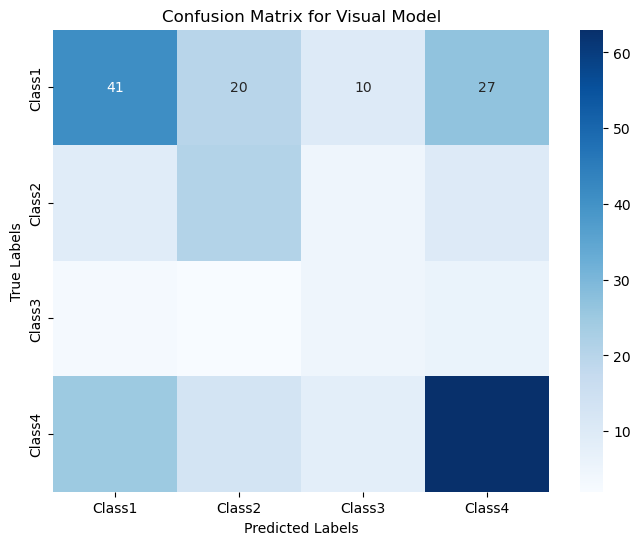

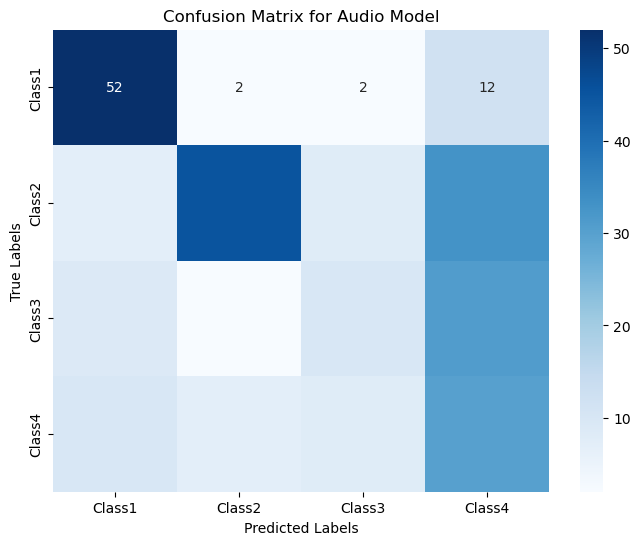

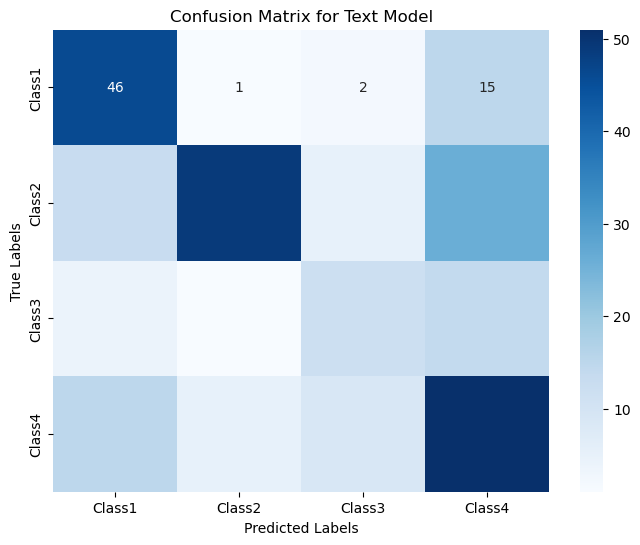

KeyError: 'val_preds'

In [19]:
classes = ['Class1', 'Class2', 'Class3', 'Class4']

for feature_type, outputs in model_outputs.items():
    cm = confusion_matrix(outputs['val_preds'], outputs['val_labels'])

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot = True, fmt = "d", cmap = "Blues", xticklabels = classes, yticklabels = classes)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    modality = feature_type.split('_')[1]  
    plt.title(f'Confusion Matrix for {modality.capitalize()} Model')
    plt.show()

In [24]:
def train_model_for_fold(model, dataloaders, optimizer, criterion, device, feature_type, num_epochs = 50, patience = 10):

    best_val_f1 = 0
    patience_counter = 0
    model.to(device)
    
    for epoch in range(num_epochs):
        model.train()
        # print('dataloaders: ', dataloaders)
        #for inputs, labels in dataloaders['extracted_visual_features_train']:
        for inputs, labels in dataloaders[f'{feature_type}_train']:

            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        val_labels = []
        val_preds = []
        model.eval()
        with torch.no_grad():
            for inputs, labels in dataloaders[f'{feature_type}_val']:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_labels.extend(labels.cpu().numpy())
                val_preds.extend(preds.cpu().numpy())

        val_f1 = f1_score(val_labels, val_preds, average='micro')
        
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    return best_val_f1


def cross_validate_model( df, model_class, feature_type, label_column = 'emotion_labels', column = 'subject_id', n_splits = 5, batch_size = 4):
    skf = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = 42)
    subjects = df[column].unique()
    labels = df.groupby(column).first()[label_column]  
    
    f1_scores = []

    for train_subjects_idx, val_subjects_idx in skf.split(subjects, labels.loc[subjects]):
        train_subjects = subjects[train_subjects_idx]
        val_subjects = subjects[val_subjects_idx]
        train_idx = df[df[column].isin(train_subjects)].index
        val_idx = df[df[column].isin(val_subjects)].index
        
        dataloaders = {}
        y_train = torch.tensor(df.loc[train_idx, label_column].values, dtype = torch.long)
        y_val = torch.tensor(df.loc[val_idx, label_column].values, dtype = torch.long)
        
    # for feature_type in feature_columns:
        X_train = np.array(df.loc[train_idx, feature_type].tolist(), dtype = np.float32)
        X_val = np.array(df.loc[val_idx, feature_type].tolist(), dtype = np.float32)
        
        train_dataset = TensorDataset(torch.tensor(X_train), y_train)
        val_dataset = TensorDataset(torch.tensor(X_val), y_val)
        
        train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True,  drop_last = True)
        val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False,  drop_last = True)
        
        dataloaders[f'{feature_type}_train'] = train_loader
        dataloaders[f'{feature_type}_val'] = val_loader

        # print(dataloaders)
        model = model_class().to(device)
        optimizer = optim.Adam(model.parameters(), lr = 0.001)
        criterion = nn.CrossEntropyLoss()

        fold_best_val_f1 = train_model_for_fold(model, dataloaders, optimizer, criterion, device, feature_type, num_epochs = 50, patience = 40)
        f1_scores.append(fold_best_val_f1)
        # print("curr f1:" , fold_best_val_f1)

    mean_f1 = np.mean(f1_scores)
    std_f1 = np.std(f1_scores)
    print(f"{column} Mean F1 across folds: {mean_f1:.4f} ± {std_f1:.4f}")
    print(column, " 5 fold validation: ", f1_scores)


In [21]:
feature_model_dict = {'visual_features': ('extracted_visual_features', VisualClassifier), 'audio_features': ('extracted_audio_features', AudialClassifier), 'lexical_features': ('extracted_text_features', TextClassifier)}

cross_validate_model( df, model_class = VisualClassifier, feature_type = 'extracted_visual_features', column = 'visual_features')
cross_validate_model( df, model_class = AudialClassifier, feature_type = 'extracted_audio_features',  column = 'acoustic_features')
cross_validate_model( df, model_class = TextClassifier,   feature_type = 'extracted_text_features',   column = 'lexical_features')

visual_features  5 fold validation:  [0.503731343283582, 0.5492424242424242, 0.5454545454545454, 0.5492424242424242, 0.5871212121212122]
Early stopping triggered at epoch 44
Early stopping triggered at epoch 50
acoustic_features  5 fold validation:  [0.585820895522388, 0.5568181818181818, 0.5757575757575758, 0.5378787878787878, 0.5984848484848485]
Early stopping triggered at epoch 50
lexical_features  5 fold validation:  [0.667910447761194, 0.6553030303030303, 0.6477272727272727, 0.6439393939393939, 0.6212121212121212]


4. Provide an interpretation of your results from the performed unimodal and multimodal classification tasks.
Which one is performing best and why

In this scenario, early and late fusion preform very similarly, with over 70% val acc and .70 F1 micro score. This variable changes but overall they are the same and simple gradient step is the difference between the accuracies and f1 scores. 
 
Betwee nthe 3 Unimodal classification tasks, Text classifcation perfoms the best with an an F1 score ranging from 0.62 to 0.67. Text and Audio perform very similarly with around a 0.55 F1 Score. I believe text pefroms best due to its semantically more meaniful embedding dimension starting at 128 input dimension versus the much larger two modalties. 